# Data Prep - Presidential Elections Data

## 1-Import libraries

In [388]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

import os
import pivottablejs as pvt
from tabula import read_pdf

%matplotlib inline

In [389]:
# set the right foldername
DATA = './presidential/'
MAIN = './'

## 2 - Load & Combine Election Results and Voter Registration data

In [390]:
# Read in both sets
dvoters = pd.read_excel("zimvotersroll2018_bypollingstation.xlsx")
dresults = pd.read_excel("zimelectionresults2018_bypollingstation.xlsx")
print(dvoters.shape, dresults.shape)

(10985, 13) (10973, 34)


In [391]:
# Format province column for results
dresults['province'] = dresults['province'].apply(lambda x: x[15:])


In [392]:
dvoters.head(2)

,polling_station_code,polling_station_name,ward,local_authority,constituency,province,tot_count,male_count,male_pct,female_count,female_pct,total_age,mean_age
0,0200BBE0101,Chikwalakwala Primary School,1,Beitbridge RDC,Beitbridge East,Matabeleland South,206,68,0.330097,138,0.669903,9226.579055,44.789219
1,0200BBE0102,Chipise Primary School,1,Beitbridge RDC,Beitbridge East,Matabeleland South,276,123,0.445652,153,0.554348,12003.069131,43.489381


In [393]:
dresults.head(2)

,district,constituency,local_authority,ward_no,polling_stations,station_code,busha_joseph_makamba_freezim_congress,chamisa_nelson_mdc_alliance,chikanga__everisto_washington_rebuild_zimbabwe,dzapasi_melbah_#_1980_freedom_movement_zimbabwe,...,mujuru_joice_teurai_ropa_prc,munyanduri_tenda_peter_npf,mutinhiri_ambrose_npf,shumba_kuzozvirava_doniel_uda,wilson_peter_harry_dop,total_votes_rejected,ballot_paper_unaccounted_for,total_votes_cast,total_valid_votes_cast,province
0,Bulawayo,Bulawayo Central,Bulawayo Municipality,1,City Hall A,0801BYO0101 A,1.0,511,0,0.0,...,1.0,0.0,0.0,1.0,0.0,10.0,0.0,754,744,Bulawayo Metropolitan Province
1,Bulawayo,Bulawayo Central,Bulawayo Municipality,1,City Hall B,0801BYO0101 B,1.0,491,1,0.0,...,1.0,0.0,0.0,0.0,0.0,6.0,0.0,740,734,Bulawayo Metropolitan Province


In [394]:
dvoters.columns

Index(['polling_station_code', 'polling_station_name', 'ward',
       'local_authority', 'constituency', 'province', 'tot_count',
       'male_count', 'male_pct', 'female_count', 'female_pct', 'total_age',
       'mean_age'],
      dtype='object')

In [395]:
dvoters.province.dtype

dtype('O')

In [396]:
# Clean up the text columns
for c in dvoters.columns[dvoters.dtypes == 'object']:
    print(c)
    dvoters.loc[:,c] = dvoters[c].apply(lambda x: str(x).strip().lower()) 
    
# Clean up the text columns
for c in dresults.columns[dresults.dtypes == 'object']:
    print(c)
    dresults.loc[:,c] = dresults[c].apply(lambda x: str(x).strip().lower()) 

polling_station_code
polling_station_name
local_authority
constituency
province
district
constituency
local_authority
polling_stations
station_code
kasiyamhuru_blessing_zpp
province


In [397]:
# join the two datasets
d_prep = pd.merge(dvoters, dresults, how="left", left_on=["polling_station_code"], right_on =["station_code"], suffixes=["_vot", "_res"])

In [398]:
d_prep.shape

(10992, 47)

In [399]:
d_prep.head(2)

,polling_station_code,polling_station_name,ward,local_authority_vot,constituency_vot,province_vot,tot_count,male_count,male_pct,female_count,...,mujuru_joice_teurai_ropa_prc,munyanduri_tenda_peter_npf,mutinhiri_ambrose_npf,shumba_kuzozvirava_doniel_uda,wilson_peter_harry_dop,total_votes_rejected,ballot_paper_unaccounted_for,total_votes_cast,total_valid_votes_cast,province_res
0,0200bbe0101,chikwalakwala primary school,1,beitbridge rdc,beitbridge east,matabeleland south,206,68,0.330097,138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0200bbe0102,chipise primary school,1,beitbridge rdc,beitbridge east,matabeleland south,276,123,0.445652,153,...,1.0,3.0,1.0,1.0,0.0,15.0,NaN,189.0,174.0,matabeleland south province


## 3- Investigate Missing data

In [400]:
# See the null columns
d_prep.isnull().sum()

polling_station_code                                   0
polling_station_name                                   0
ward                                                   0
local_authority_vot                                    0
constituency_vot                                       0
province_vot                                           0
tot_count                                              0
male_count                                             0
male_pct                                               0
female_count                                           0
female_pct                                             0
total_age                                              0
mean_age                                               0
district                                              22
constituency_res                                      22
local_authority_res                                   22
ward_no                                               22
polling_stations               

In [401]:
unmatched_ps = d_prep[d_prep["station_code"].isnull()]

In [402]:
unmatched_ag = unmatched_ps[["province_vot","tot_count"]].groupby(["province_vot"]).agg(["sum", "count"])

In [403]:
unmatched_ag

tot_count      
                            sum count
province_vot                         
bulawayo metropolitan       875     1
harare metropolitan         705     1
manicaland                  729     2
mashonaland central         876     1
mashonaland east           1142     4
mashonaland west            305     1
masvingo                   2335     7
matabeleland north         1306     3
matabeleland south          206     1
midlands                    325     1

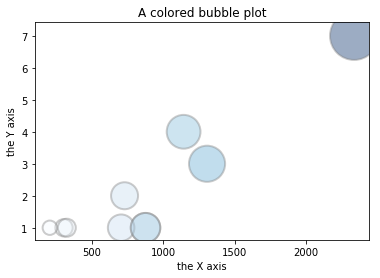

In [404]:
# create data
x = unmatched_ag.iloc[:,0]
y = unmatched_ag.iloc[:,1]
lb = list(unmatched_ag.index)
 
# Change color with c and alpha. I map the color to the X axis value.
plt.scatter(x, y, s=x, c=x, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)
 
# Add titles (main and on axis)
plt.xlabel("the X axis")
plt.ylabel("the Y axis")
plt.title("A colored bubble plot")
plt.show()

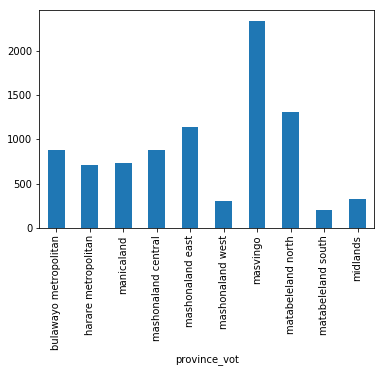

In [405]:
#unmatched_ag
unmatched_ag.iloc[:,0].plot(kind='bar')

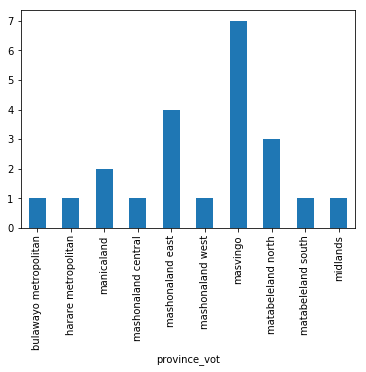

In [406]:
unmatched_ag.iloc[:,1].plot(kind='bar')

In [407]:
# Remove the nulls
d_election = d_prep[d_prep['station_code'].notnull()]; d_election.isnull().sum()

polling_station_code                                   0
polling_station_name                                   0
ward                                                   0
local_authority_vot                                    0
constituency_vot                                       0
province_vot                                           0
tot_count                                              0
male_count                                             0
male_pct                                               0
female_count                                           0
female_pct                                             0
total_age                                              0
mean_age                                               0
district                                               0
constituency_res                                       0
local_authority_res                                    0
ward_no                                                0
polling_stations               

In [408]:
# Replace remaining nulls with Zero-value
d_election = d_election.fillna(0); d_election.isnull().sum().sum()

0

In [409]:
# Some random strings in these numbers, set to 0
nan_string = d_election[d_election['kasiyamhuru_blessing_zpp']=='nan'].index
d_election.loc[nan_string,'kasiyamhuru_blessing_zpp'] = 0

#print (d_election[d_election['kasiyamhuru_blessing_zpp'].apply(lambda x: isinstance(x, str))])
#d_election['kasiyamhuru_blessing_zpp'].apply(lambda x: pd.to_numeric(str(x).strip()))

## Investigate "New" and Duplicated Polling Stations

In [434]:
missing = set(dvoters['polling_station_code']) - set(dresults['station_code'])
new = set(dresults['station_code']) - set(dvoters['polling_station_code'])
dups = dresults['station_code'][dresults['station_code'].duplicated()]

In [424]:
missing

{'0200bbe0101',
 '0400bkt1401',
 '0501bmu0101 a',
 '0700buh1601',
 '0801byo0301',
 '1200chv1801',
 '1200chv1802',
 '1200chv1803',
 '1200chv1804',
 '1200chv1805',
 '1200chv1806',
 '1800chik0301',
 '3200che0201',
 '4100kus2701',
 '4700mre2707',
 '6301hre3104 b',
 '7500mtr0802',
 '7700tak0101',
 '8000wed1303',
 '8400umg1607',
 '8400umg1608',
 '8500zva0502 a'}

In [425]:
new

{'4700mre270', '8400umg1607 a', '8400umg1608 b'}

In [435]:
dups

856     6301hre3104 a
6999      0400bkt2101
7000      0400bkt2102
7001      0400bkt2103
7002      0400bkt2104
7003      0400bkt2105
7004      0400bkt2106
Name: station_code, dtype: object

## 3- Summary Statistics

In [410]:
d_election.columns

Index(['polling_station_code', 'polling_station_name', 'ward',
       'local_authority_vot', 'constituency_vot', 'province_vot', 'tot_count',
       'male_count', 'male_pct', 'female_count', 'female_pct', 'total_age',
       'mean_age', 'district', 'constituency_res', 'local_authority_res',
       'ward_no', 'polling_stations', 'station_code',
       'busha_joseph_makamba_freezim_congress', 'chamisa_nelson_mdc_alliance',
       'chikanga__everisto_washington_rebuild_zimbabwe',
       'dzapasi_melbah_#_1980_freedom_movement_zimbabwe',
       'gava_peter_mapfumo_udf', 'hlabangana_kwanele_rpz',
       'kasiyamhuru_blessing_zpp', 'khupe_thokozani_mdc-t',
       'madhuku_lovemore_nca', 'mangoma_elton_steers_coalition_of_democrats',
       'manyika_noah_ngoni_bza',
       'mapfumo_chiguvare_tonderayi_johannes_timothy_pppz',
       'mariyacha_violet_udm', 'mhambi-hove_divine_napdr',
       'mnangagwa_emmerson_dambudzo_zanu_pf', 'moyo_donald_nkosana_apa',
       'mteki_bryn_taurai_independent'

### a) Get columns for candidates other than Chamisa and Mnangagwa

In [411]:
# extract columns
other_cols = ['busha_joseph_makamba_freezim_congress',
#'chamisa_nelson_mdc_alliance',
    'chikanga__everisto_washington_rebuild_zimbabwe',
       'dzapasi_melbah_#_1980_freedom_movement_zimbabwe',
       'gava_peter_mapfumo_udf', 'hlabangana_kwanele_rpz',
       'kasiyamhuru_blessing_zpp', 'khupe_thokozani_mdc-t',
       'madhuku_lovemore_nca', 'mangoma_elton_steers_coalition_of_democrats',
       'manyika_noah_ngoni_bza',
       'mapfumo_chiguvare_tonderayi_johannes_timothy_pppz',
       'mariyacha_violet_udm', 'mhambi-hove_divine_napdr',
#'mnangagwa_emmerson_dambudzo_zanu_pf', 
    'moyo_donald_nkosana_apa',
       'mteki_bryn_taurai_independent', 'mugadza_willard_tawonezvi_bcp',
       'mujuru_joice_teurai_ropa_prc', 'munyanduri_tenda_peter_npf',
       'mutinhiri_ambrose_npf', 'shumba_kuzozvirava_doniel_uda',
       'wilson_peter_harry_dop']

In [412]:
# Calculate the totals and make new column in df
others = d_election[other_cols].sum(axis=1)
d_election['others_excl_NCandED'] = others
# Drop individual others, now redundant
d_election.drop(other_cols, axis=1, inplace=True)

In [413]:
d_election.head(1)

,polling_station_code,polling_station_name,ward,local_authority_vot,constituency_vot,province_vot,tot_count,male_count,male_pct,female_count,...,polling_stations,station_code,chamisa_nelson_mdc_alliance,mnangagwa_emmerson_dambudzo_zanu_pf,total_votes_rejected,ballot_paper_unaccounted_for,total_votes_cast,total_valid_votes_cast,province_res,others_excl_NCandED
1,0200bbe0102,chipise primary school,1,beitbridge rdc,beitbridge east,matabeleland south,276,123,0.445652,153,...,chipise primary school,0200bbe0102,33.0,113.0,15.0,0.0,189.0,174.0,matabeleland south province,23.0


In [414]:
d_election.columns

Index(['polling_station_code', 'polling_station_name', 'ward',
       'local_authority_vot', 'constituency_vot', 'province_vot', 'tot_count',
       'male_count', 'male_pct', 'female_count', 'female_pct', 'total_age',
       'mean_age', 'district', 'constituency_res', 'local_authority_res',
       'ward_no', 'polling_stations', 'station_code',
       'chamisa_nelson_mdc_alliance', 'mnangagwa_emmerson_dambudzo_zanu_pf',
       'total_votes_rejected', 'ballot_paper_unaccounted_for',
       'total_votes_cast', 'total_valid_votes_cast', 'province_res',
       'others_excl_NCandED'],
      dtype='object')

In [415]:
d_election.shape

(10970, 27)

### b) New features - voter turnout etc.

In [416]:
# Voter turnout
d_election['voter_turnout_valid'] = d_election['total_valid_votes_cast']/d_election['tot_count']
d_election['voter_turnout_cast'] = d_election['total_votes_cast']/d_election['tot_count']

# Spoiled votes
d_election['rejected_pct'] = d_election['total_votes_rejected']/d_election['total_votes_cast']
d_election['unaccounted_pct'] = d_election['ballot_paper_unaccounted_for']/d_election['total_votes_cast']

# Candidates
d_election['mnangagwa_pct'] = d_election['mnangagwa_emmerson_dambudzo_zanu_pf']/d_election['total_valid_votes_cast']
d_election['chamisa_pct'] = d_election['chamisa_nelson_mdc_alliance']/d_election['total_valid_votes_cast']
d_election['others_pct'] = d_election['others_excl_NCandED']/d_election['total_valid_votes_cast']

# Check mathematics
d_election['check_sum_valid'] = (d_election['chamisa_nelson_mdc_alliance']+ d_election['mnangagwa_emmerson_dambudzo_zanu_pf']+ d_election['others_excl_NCandED'])/d_election['total_valid_votes_cast']
d_election['check_sum_cast'] = (d_election['chamisa_nelson_mdc_alliance']+ d_election['mnangagwa_emmerson_dambudzo_zanu_pf']+ d_election['others_excl_NCandED'])/d_election['total_votes_cast']

In [417]:
d_election.head(2)

,polling_station_code,polling_station_name,ward,local_authority_vot,constituency_vot,province_vot,tot_count,male_count,male_pct,female_count,...,others_excl_NCandED,voter_turnout_valid,voter_turnout_cast,rejected_pct,unaccounted_pct,mnangagwa_pct,chamisa_pct,others_pct,check_sum_valid,check_sum_cast
1,0200bbe0102,chipise primary school,1,beitbridge rdc,beitbridge east,matabeleland south,276,123,0.445652,153,...,23.0,0.630435,0.684783,0.079365,0.0,0.649425,0.189655,0.132184,0.971264,0.894180
2,0200bbe0103,chituripasi primary school,1,beitbridge rdc,beitbridge east,matabeleland south,474,185,0.390295,289,...,43.0,0.732068,0.746835,0.019774,0.0,0.688761,0.181556,0.123919,0.994236,0.974576


## Finally, save the election file ready for analysis

In [436]:
# save to excel
d_election.to_excel("election_data_clean_forScript.xlsx")
dvoters.to_excel("votersroll_bypolstat_clean.xlsx")
dresults.to_excel("results_bypolstat_clean.xlsx")
unmatched_ps.to_excel("pollingstations_inVRnotinRes.xlsx")

----
# END of prep Script
----